# Optimization Algorithms for Markowitz Portfolio Problem
<hr>

## Environment Set Up

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [2]:
"""
Environment variable

EPSILON: constant used for the stopping criteria
MAX_ITER: maximium numer of iteration allowed (in frank-wolfe algorithm)
MAX_ITER_PGM: maximium numer of iteration allowed (in projected gradient algorithm)
COLOR_1: color used for plots
"""
EPSILON = 1e-5
MAX_ITER = int(1 / EPSILON)
MAX_ITER_PGM = 5000
COLOR_1 = '#d63227'

## Loading Dataset and Problem Set Up

In [3]:
def load_dataset(dataset=1):
    """
    This function loads the specified dataset. The dataset can be used to implement
    the Markowitz portfolio problem. There are two available datasets:
    - Dataset 1: SP_500
    - Dataset 2: EuroStoxx50

    Args:
    dataset (int): Load SP_500 if equal to 1, load EuroStoxx50 if equal to 2

    Returns:
    name (str): dataset name
    n (int): number of available assets
    r (np.ndarray): expected return on assets
    sigma (np.ndarray): covariance matrix
    """
    
    if dataset == 1:
        
        name = 'SP_500'
        path = os.path.join("Datasets", "SP_500", "data")

        r = np.genfromtxt(fname = os.path.join(path, 'MRet476.txt'))
        sigma = np.genfromtxt(fname = os.path.join(path, 'Cov476.txt'))
        n = r.shape[0]

    elif dataset == 2:
        
        name = 'EUROSTOXX_50'
        path = os.path.join("Datasets", "EUROSTOXX_50", "data")

        r = np.genfromtxt(fname = os.path.join(path, 'MRet48.txt'))
        sigma = np.genfromtxt(fname = os.path.join(path, 'Cov48.txt'))
        n = r.shape[0]

    else:
        
        name = 'SYNTHETIC_DATA'

        n = 10
        r = np.random.normal(size=n)
        var = np.random.normal(size=n).reshape(1, -1)
        sigma = var.T @ var
        
        x = np.random.randint(0, 100, n)
        x = x / sum(x)
    
    return name, n, r, sigma

### Variables initialization
Here, we load the specified dataset and set up the Markowitz portfolio problem initializing the following variables:

<code>n</code> : number of available assets

<code>r</code> : expected return on assets

<code>sigma</code> : covariance matrix

<code>eta</code> : risk-aversion parameter (must be > 0)

<code>x</code> : amount invested in each asset

In [4]:
name, n, r, sigma = load_dataset(dataset=2) # Loading the dataset
eta = 1 # It can be chosen arbitrarily (must be > 0)
x = np.zeros(n) # Initialized as a vector of zeros

print(
f'''
Dataset Description

Name: {name}
Number of Stocks: {n}
Risk-aversion parameter (eta) = {eta}
Expected return vector shape: {r.shape}
Covariance Matrix shape: {sigma.shape}
'''
)


Dataset Description

Name: EUROSTOXX_50
Number of Stocks: 48
Risk-aversion parameter (eta) = 1
Expected return vector shape: (48,)
Covariance Matrix shape: (48, 48)



## Objective function and its Gradient

The objective function can be expressed as:
\begin{align*}
f(x) = \eta \cdot \textit{x}^\top\Sigma\textit{x} - \bar{r}^\top\textit{x}
\end{align*}

In [5]:
def f(x):
    '''
    This function compute the cost function w.r.t. x, for the Markowitz problem
    '''
    return eta * (x.T @ sigma @ x) - r.T @ x

In [6]:
f(x)

0.0

The gradient of the objective function can be expressed as:
\begin{align*}
    \nabla f(x) = \eta \cdot (x^\top \Sigma + \Sigma x) - \bar{r}
\end{align*}

In [7]:
def gradient(x):
    '''
    This function compute the gradient of the cost function w.r.t. x, for the Markowitz problem
    '''
    return eta * ((x @ sigma).T + (sigma @ x)) - r

In [8]:
np.min(gradient(x))

-0.01149914278

## Other support functions

In [9]:
def print_weights(x):
    '''
    This function prints the optimal weights assigned to assets in the portfolio in a human-readable format.
    
    Args:
    x (np.ndarray): Array containing the weights assigned to different assets in a portfolio.
    
    Returns:
    None
    '''
    print('-'*40)
    print(f'Optimal weights (for eta = {eta}):')
    print('-'*40)
    for i in np.where(x > 0)[0]:
        print(f'Asset {i+1}: x = {x[i]*100:.2f}%')
    return

In [10]:
x = np.array([0., 0.3, 0., 0.7])
print_weights(x)

----------------------------------------
Optimal weights (for eta = 1):
----------------------------------------
Asset 2: x = 30.00%
Asset 4: x = 70.00%


In [11]:
def line_search(fun, dk, xk, min_gamma, max_gamma, n_step=100, verbosity=False):
    '''
    This function performs a line search to find the best step size 'gamma' that minimizes the given objective 
    function 'fun' along the direction defined by 'dk' starting from the point 'xk'. The search is constrained 
    within the range (min_gamma, max_gamma]. The number of steps in the linear search is controlled by 'n_step'.
    
    Args:
        fun (callable): The objective function to be minimized.
        dk (np.ndarray): The search direction vector.
        xk (np.ndarray): The current point in the search space.
        min_gamma (float): The minimum allowable step size (exclusive).
        max_gamma (float): The maximum allowable step size (inclusive).
        n_step (int, optional): The number of steps to perform in the linear search. Default is 100.

    Returns:
        float: The optimal step size (gamma) within the specified range that minimizes the objective function.
        
    '''
    gamma = max_gamma # Initial assignment
    beta = max_gamma
    step_size_reduction = (max_gamma - min_gamma) / n_step
    
    if verbosity:
        print(f'step_size_reduction {step_size_reduction}\n')
        print(f'beta {beta}')
    
    while beta >= min_gamma :
        if fun(xk + beta * dk) < fun(xk + gamma * dk):
            gamma = beta
            
        beta = beta - step_size_reduction
        if beta < min_gamma:
            break
            
        if verbosity: 
            print(f'beta {beta}')
    
    if verbosity:
        print()
        print(f'gamma {gamma}', end=''*5)
    
    return gamma

In [12]:
line_search(lambda x: x@x, np.array([0, 1]), np.array([0, 0.5]), min_gamma=0, max_gamma=1, verbosity=False)

0.009999999999999247

In [13]:
def plot_convergence(x_values, y_values, title='Convergence', xlabel='Iterations', ylabel='Duality Gap', color=COLOR_1):
    """
    Plots the convergence of the algorithm.

    Args:
    x_values (list)
    y_values (list)

    Returns:
    None
    """
    # Plot style settings
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['axes.linewidth'] = 0.8
    plt.rcParams['axes.grid'] = False
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 0.8

    # Generate the plot
    plt.figure(figsize=(10, 5))
    plt.plot(x_values, y_values, linestyle='-', color=color)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(label=title, fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

## Algorithms implementation

### 1. Frank-Wolfe Method

In [14]:
def frank_wolfe(n, r, sigma, eta):
    """
    Implementation of the Frank-Wolfe method (for unit simplex).

    Args:
    n (int): Number of available assets.
    r (np.ndarray): Returns on assets.\
    sigma (np.ndarray): Covariance matrix.
    eta (float): Risk-aversion parameter (must be > 0).

    Return:
    x (np.ndarray): Optimal amount invested in each asset.
    iterations (list): A list containing the number of iterations at each step.
    duality_gap_values (list): A list recording the duality gap values at each iteration.
    f_values (list): A list recording the objective function values at each iteration.

    """

    # Initialize variables
    s = np.zeros(n)  # Initialize s
    gamma = 0  # Initialize gamma
    duality_gap = 0  # Initialize duality gap

    # Initialize x array to one of the atoms of the simplex
    x = np.zeros(n)
    i = np.random.randint(low=0, high=n)
    x[i] = 1

    # Initialize lists to track convergence
    duality_gap_values = []  # To record duality gap values
    iterations = []  # To record the number of iterations
    f_values = [] # To record objective function values

    for k in range(MAX_ITER):

        # Set s = e_i
        i = np.argmin(gradient(x))
        s = np.zeros(n)
        s[i] = 1
        
        # Compute the duality gap as a stopping criterion
        duality_gap = -gradient(x).T @ (s - x)
        duality_gap_values.append(duality_gap)  # Record duality gap value
        iterations.append(k)  # Record the number of iterations
        f_values.append(f(x)) # Record cost function value

        if k%(MAX_ITER//100)==0 or k==MAX_ITER-1 or duality_gap <= EPSILON:
            print(f'>>> Iter {k:04d}', end=' '*5)
            print(f'i = {i}', end=' '*5)
            print(f'f(x) = {f(x):.2e}', end=' '*5)
            print(f'gap = {duality_gap:.2e}', end=' '*5)
            #print(f'gamma = {gamma:.3f}', end=' '*5)
            print()
            
        # Check the stopping condition based on the duality gap
        if duality_gap <= EPSILON:
            print(f'Stopping criteria reached')
            break
        
        # Line search to find the optimal step size gamma in the range (0, gamma_hat]
        gamma = line_search(fun=f, dk=(s - x), xk=x, min_gamma=0, max_gamma=1, n_step=100)
        
        # Compute the update step
        x = x + gamma * (s - x)

    print(f'Stopping alghorithm after {k+1} iterations\n')

    return x, iterations, duality_gap_values, f_values


In [15]:
x_FW, iterations_FW, duality_gap_values_FW, f_values_FW = frank_wolfe(n, r, sigma, eta)

>>> Iter 0000     i = 22     f(x) = -1.58e-04     gap = 1.21e-02     
>>> Iter 0186     i = 17     f(x) = -7.44e-03     gap = 7.46e-06     
Stopping criteria reached
Stopping alghorithm after 187 iterations



In [16]:
print_weights(x_FW)

----------------------------------------
Optimal weights (for eta = 1):
----------------------------------------
Asset 17: x = 0.08%
Asset 18: x = 18.29%
Asset 23: x = 25.63%
Asset 27: x = 13.96%
Asset 29: x = 24.78%
Asset 39: x = 17.27%


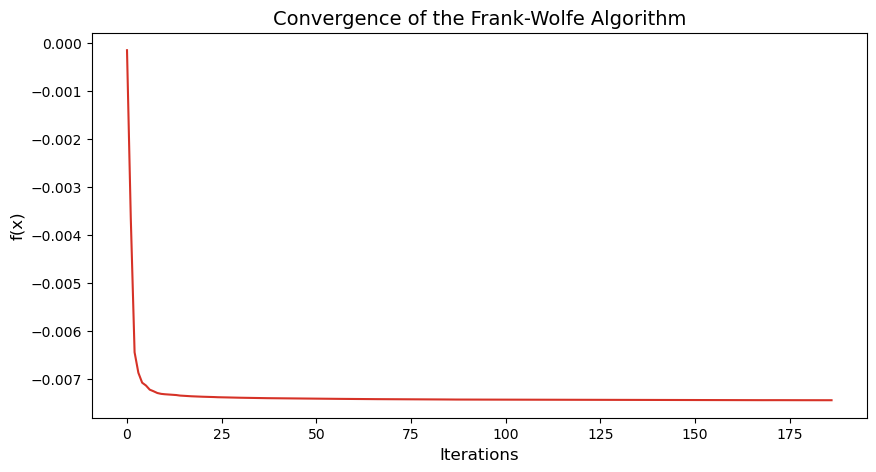

In [17]:
plot_convergence(iterations_FW, f_values_FW, title='Convergence of the Frank-Wolfe Algorithm', ylabel='f(x)')

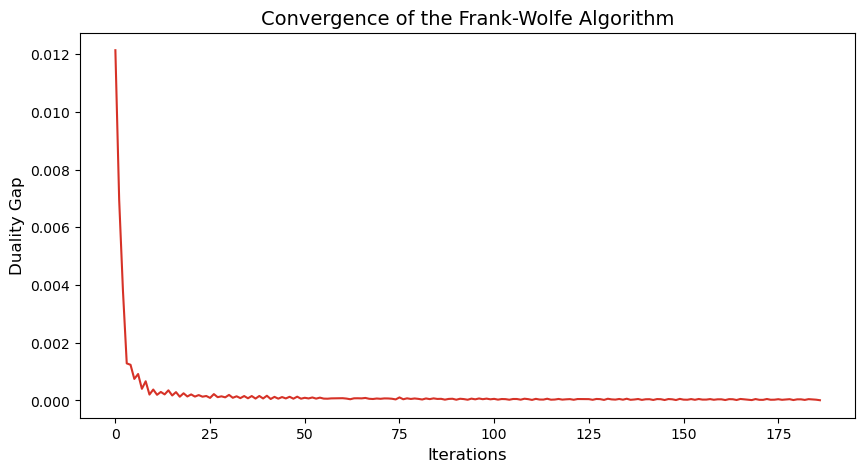

In [18]:
plot_convergence(iterations_FW, duality_gap_values_FW, title='Convergence of the Frank-Wolfe Algorithm')

### 2. Pariwise Frank-Wolfe Method

In [19]:
def pairwise_frank_wolfe(n, r, sigma, eta):
    """
    Implementation of the Pairwise Frank-Wolfe method (for the unit simplex).

    Args:
    n (int): number of available assets
    r (np.ndarray): returns on assets
    sigma (np.ndarray): covariance matrix
    eta (float): risk-aversion parameter (must be > 0)

    Returns:
    x (np.ndarray): optimal investment amounts in each asset
    iterations (list): A list containing the number of iterations at each step.
    duality_gap_values (list): A list recording the duality gap values at each iteration.
    f_values (list): A list recording the objective function values at each iteration.

    """

    # Initialize variables
    s = np.zeros(n) # search atom
    v = np.zeros(n) # away atom
    d_FW = np.zeros(n)
    d_AS = np.zeros(n)
    d = np.zeros(n)
    gamma = 0
    gamma_max = 0
    active_set = []  # active set, i.e., a list containing the previously discovered search atoms

    # Initialize the x array to one of the atoms of the simplex
    x = np.zeros(n)
    i_FW = np.random.randint(low=0, high=n)
    i_AS = 0
    x[i_FW] = 1
    active_set.append(x)  # add this atom to the active set

    # Initialize lists to track convergence
    duality_gap_values = []  # To record duality gap values
    iterations = []  # To record the number of iterations
    f_values = [] # To record cost function values

    for k in range(MAX_ITER):

        # Compute the gradient of f(x) with respect to the current iterate x
        grad = gradient(x)

        # Set s
        i_FW = np.argmin(grad)
        s = np.zeros(n)
        s[i_FW] = 1
     
        # Set v
        if active_set:
            v = active_set[0]
            for z in active_set[1:]:
                if (grad @ (z - x)) > (grad @ (v - x)):
                    v = z
        i_AS = np.where(v > 0)[0][0]
        
        # Set Frank-Wolfe direction and away-step direction
        d_FW = s - x
        d_AS = x - v

        # Set direction d
        d = d_FW + d_AS

        # Compute the duality gap as a stopping criterion
        duality_gap = -grad.T @ d_FW
        duality_gap_values.append(duality_gap)  # Record duality gap value
        iterations.append(k)  # Record the number of iterations
        f_values.append(f(x)) # Record cost function value

        if k%(MAX_ITER//10)==0 or k==MAX_ITER-1 or duality_gap <= EPSILON:
            print(f'>>> Iter {k:03d}', end=' ' * 5)
            print(f'i_FW = {i_FW}', end=' ' * 5)
            print(f'i_AS = {i_AS}', end=' ' * 5)
            print(f'f(x) = {f(x):.2e}', end=' ' * 5)
            print(f'gap = {duality_gap:.2e}', end=' ' * 5)
            print(f'active_set = {[np.where(a > 0)[0][0] for a in active_set]}', end=' ' * 5)
            print()

        # Check the stopping condition based on the duality gap
        if duality_gap <= EPSILON:
            print(f'Stopping criteria reached')
            break

        # Set the maximum feasible step size (gamma_max)
        gamma_max = x[i_AS]

        # Line search to find the optimal step size gamma in the range (0, gamma_max]
        gamma = line_search(fun=f, dk=d, xk=x, min_gamma=0, max_gamma=gamma_max, n_step=100)

        # Compute the update step
        x = x + gamma * d
        x = x / np.sum(x)

        # Update the active set 
        if not any(np.array_equal(s, arr) for arr in active_set): # Add new atom
            active_set.append(s)
        if gamma == gamma_max: # Drop Step
            active_set.remove(v)

    print(f'Stopping algorithm after {k+1} iterations\n')

    return x, iterations, duality_gap_values, f_values


In [20]:
x_FWP, iterations_FWP, duality_gap_values_FWP, f_values_FWP = pairwise_frank_wolfe(n, r, sigma, eta)

>>> Iter 000     i_FW = 22     i_AS = 35     f(x) = -2.76e-03     gap = 9.49e-03     active_set = [35]     
>>> Iter 010     i_FW = 22     i_AS = 17     f(x) = -7.44e-03     gap = 8.48e-06     active_set = [22, 28, 38, 26, 17]     
Stopping criteria reached
Stopping algorithm after 11 iterations



In [21]:
print_weights(x_FWP)

----------------------------------------
Optimal weights (for eta = 1):
----------------------------------------
Asset 18: x = 19.38%
Asset 23: x = 25.56%
Asset 27: x = 13.64%
Asset 29: x = 24.45%
Asset 39: x = 16.97%


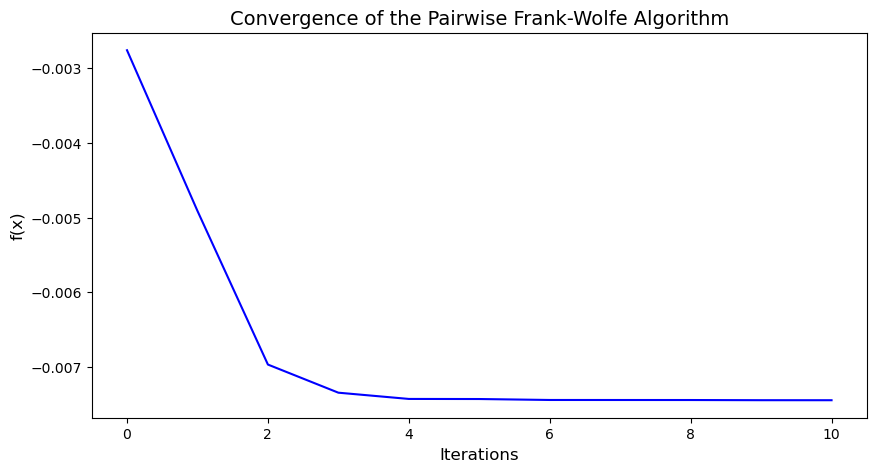

In [22]:
plot_convergence(iterations_FWP[:], f_values_FWP[:], title='Convergence of the Pairwise Frank-Wolfe Algorithm', ylabel='f(x)', color='blue')

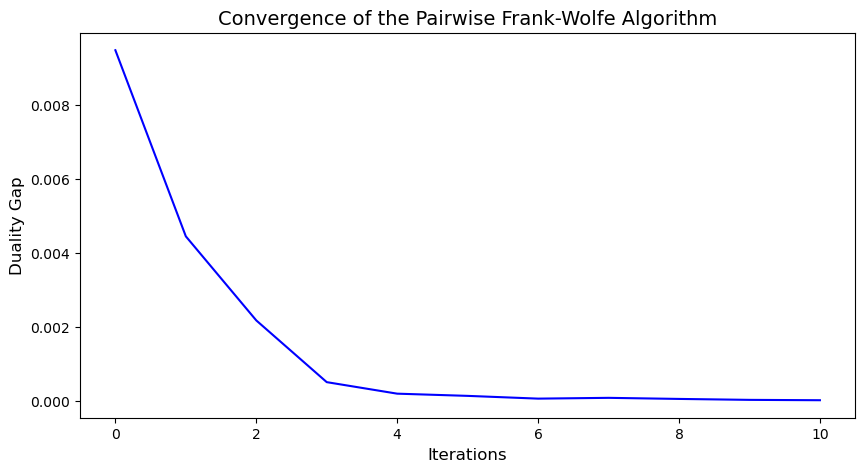

In [23]:
plot_convergence(iterations_FWP[:], duality_gap_values_FWP[:], title='Convergence of the Pairwise Frank-Wolfe Algorithm', color='blue')

### 3. Projected Gradient Method

In [24]:
def project_onto_simplex(y):
    '''
    Projects a given vector onto the unit simplex. The algorithm used for projection is based on the algorithm 1 
    described in the paper "Fast projection onto the simplex and the l1 ball" - (Condat 2016). 
    (https://doi.org/10.1007/s10107-015-0946-6)

    Args:
    y (np.ndarray): The input vector to be projected onto the simplex.

    Returns:
    np.ndarray: The projected vector that satisfies the constraints of a unit simplex.
    
    The function takes an input vector 'y' and projects it onto a probability simplex, ensuring that the resulting vector
    satisfies the conditions of a probability distribution, where all elements are non-negative and sum up to 1. The
    algorithm used for projection is based on the "Smallest Simplex Projection" method.
    
    '''
    
    n = y.shape[0]
    a = 1 # 'a' represent the target sum of the projected vector
    
    # Sort 'y' into 'u' in descending order.
    u = np.sort(y)[::-1]
    
    # Find the largest index 'k' where the condition (cum_sum - a) / indices < u is met.
    cum_sum = np.cumsum(u) - a
    indices = np.arange(1, n + 1)
    k = np.max(np.where((cum_sum) / indices < u)[0])
    
    # Set 'tau'
    tau = (np.sum(u[:k+1]) - a) / (k+1)
    
    # Compute the projected vector
    x = np.maximum(y - tau, 0)

    return x


In [25]:
def projected_gradient_method(n, r, sigma, eta, s=115):
    """
    Implementation of the Projected Gradient Method.

    Args:
    n (int): number of available assets
    r (np.ndarray): returns on assets
    sigma (np.ndarray): covariance matrix
    eta (float): risk-aversion parameter (must be > 0)

    Returns:
    x (np.ndarray): optimal amount invested in each asset
    iterations (list): A list containing the number of iterations at each step.
    g_values (list): A list recording the gradient mapping values at each iteration.
    f_values (list): A list recording the objective function values at each iteration.


    """

    # Initialize variables
    x_hat = np.zeros(n)
    s = s
    gamma = 0

    # Initialize the x array to one of the atoms of the simplex
    x = np.zeros(n)
    i = np.random.randint(low=0, high=n)
    x[i] = 1

    # Initialize lists to track convergence
    g_values = []  # To record gradient mapping values
    iterations = []  # To record the number of iterations
    f_values = [] # To record cost function values

    for k in range(MAX_ITER_PGM):

        # Set x_hat as the projection of x onto the unit simplex
        x_hat = project_onto_simplex(x - s * gradient(x))

        # Compute the gradient mapping Euclidean norm as a stopping criterion
        g = distance.euclidean(x, x_hat)
        g_values.append(g)  # Record gradient mapping value
        iterations.append(k)  # Record the number of iterations
        f_values.append(f(x)) # Record cost function value
        
        if k%(MAX_ITER_PGM//10) == 0 or k == 0 or k == MAX_ITER_PGM-1 or g <= EPSILON:
            print(f'>>> Iter {k:03d}', end=' ' * 5)
            print(f'f(x) = {f(x):.2e}', end=' ' * 5)
            print(f'||g|| = {g:.2e}', end=' ' * 5)
            print()
        
        # Check the stopping condition based on the gradient mapping
        # If x is (approximately) equal to x_hat, it is a global minimum (Proposition 5.9)
        if g <= EPSILON:
            print(f'Stopping criteria reached')
            break

        # Line search to find the optimal step size gamma in the range (0, 1]
        gamma = line_search(fun=f, dk=(x_hat - x), xk=x, min_gamma=0, max_gamma=1, n_step=100)

        # Compute the update step
        x = x + gamma * (x_hat - x)

    print(f'Stopping algorithm after {k+1} iterations\n')

    return x, iterations, g_values, f_values


In [26]:
x_PGM, iterations_PGM, g_values_PGM, f_values_PGM = projected_gradient_method(n, r, sigma, eta)

>>> Iter 000     f(x) = -1.58e-04     ||g|| = 1.00e+00     
>>> Iter 070     f(x) = -7.44e-03     ||g|| = 9.76e-06     
Stopping criteria reached
Stopping algorithm after 71 iterations



In [27]:
print_weights(x_PGM)

----------------------------------------
Optimal weights (for eta = 1):
----------------------------------------
Asset 18: x = 18.68%
Asset 23: x = 25.63%
Asset 27: x = 13.95%
Asset 29: x = 24.68%
Asset 39: x = 17.05%


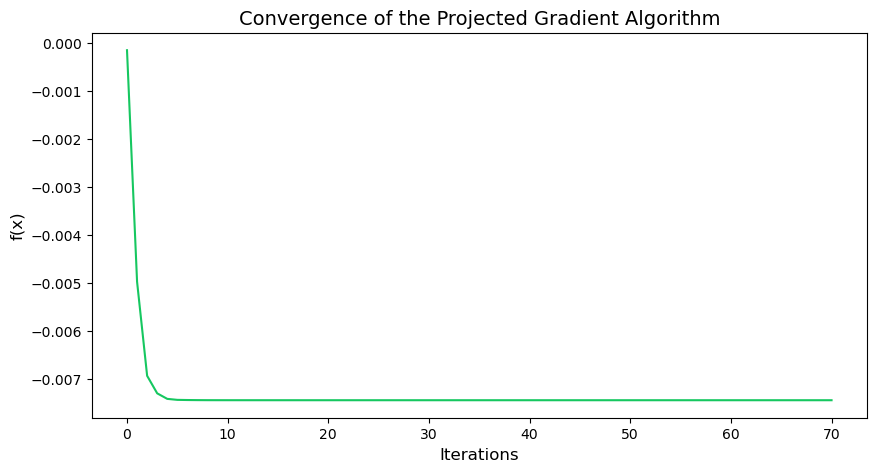

In [28]:
plot_convergence(iterations_PGM, f_values_PGM, title='Convergence of the Projected Gradient Algorithm', ylabel='f(x)', color='#16c760')

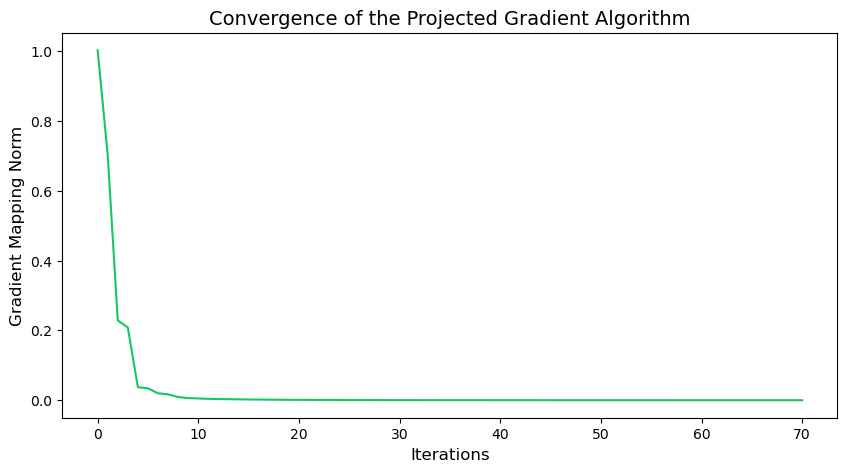

In [29]:
plot_convergence(iterations_PGM, g_values_PGM, title='Convergence of the Projected Gradient Algorithm', ylabel='Gradient Mapping Norm', color='#16c760')

## Comparisons

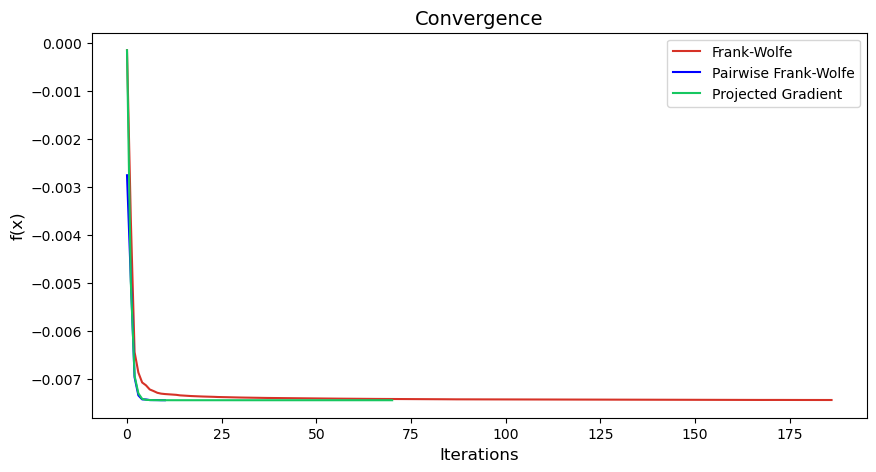

In [30]:
# Plot style settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.1

# Generate the plot
plt.figure(figsize=(10, 5))
plt.plot(iterations_FW, f_values_FW, linestyle='-', color=COLOR_1, label='Frank-Wolfe')
plt.plot(iterations_FWP, f_values_FWP, linestyle='-', color='blue', label='Pairwise Frank-Wolfe')
plt.plot(iterations_PGM, f_values_PGM, linestyle='-', color='#16c760', label='Projected Gradient')
plt.legend(fontsize=10)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.title(label='Convergence', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

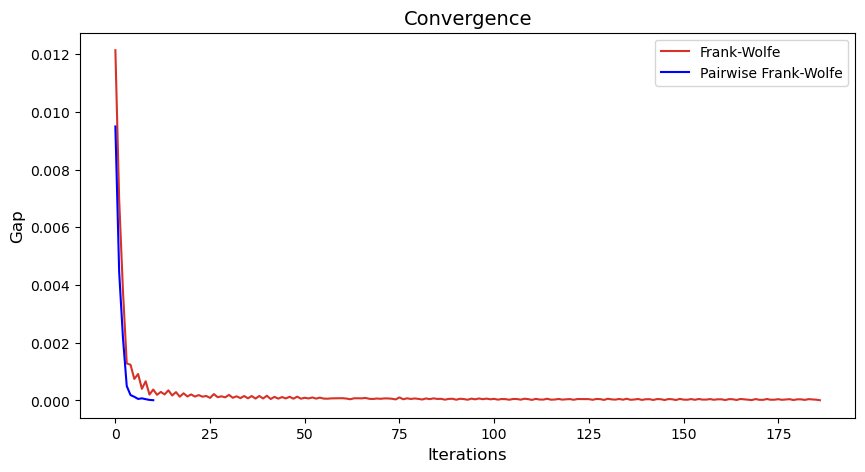

In [31]:
# Plot style settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5

# Generate the plot
plt.figure(figsize=(10, 5))
plt.plot(iterations_FW, duality_gap_values_FW, linestyle='-', color=COLOR_1, label='Frank-Wolfe')
plt.plot(iterations_FWP, duality_gap_values_FWP, linestyle='-', color='blue', label='Pairwise Frank-Wolfe')
#plt.plot(iterations_PGM, f_values_PGM, linestyle='-', color='green', label='PGM')
plt.legend(fontsize=10)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Gap', fontsize=12)
plt.title(label='Convergence', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [32]:
print('Frank-Wolfe')
print_weights(x_FW)

print('\n\nPairwise Frank-Wolfe')
print_weights(x_FWP)

print('\n\nProjected Gradient')
print_weights(x_PGM)

Frank-Wolfe
----------------------------------------
Optimal weights (for eta = 1):
----------------------------------------
Asset 17: x = 0.08%
Asset 18: x = 18.29%
Asset 23: x = 25.63%
Asset 27: x = 13.96%
Asset 29: x = 24.78%
Asset 39: x = 17.27%


Pairwise Frank-Wolfe
----------------------------------------
Optimal weights (for eta = 1):
----------------------------------------
Asset 18: x = 19.38%
Asset 23: x = 25.56%
Asset 27: x = 13.64%
Asset 29: x = 24.45%
Asset 39: x = 16.97%


Projected Gradient
----------------------------------------
Optimal weights (for eta = 1):
----------------------------------------
Asset 18: x = 18.68%
Asset 23: x = 25.63%
Asset 27: x = 13.95%
Asset 29: x = 24.68%
Asset 39: x = 17.05%
